# Data Exploration
We often get data from collaborators, online repositories, or even just generate it ourselves from a survey or analysis pipeline.  We want to get a quick idea of what the data looks like, if it has problems or features that are interesting, etc.

## Imports

In [1]:
import sys
myLibPaths = [r'/home/bizard/astronomy/python',
              r'/home/bizard/astronomy/teaching/ASTR 470 - Obs Astro/2021_Spring/coding'
             ]
for libPath in myLibPaths:
    if (libPath not in sys.path):
        sys.path.insert(0,libPath)

In [39]:
import os
import re
import numpy as np
import re
from scipy import stats

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

In [11]:
from astropy import units as u
from astropy.io import (
    fits,
    ascii,
)
from astropy import table

## Directory Paths

In [5]:
spocsdir = r'./data/spocs'
specdir = r'./data/spectra'

# SPOCS II Catalog
Brewer et al. (2016) is a catalog of stellar parameters derived from spectra of ~1600 stars.  The information includes $T_{\mathrm{eff}}$, $\log{g}$, [M/H], $v \sin{i}$, and abundances for 15 elements.  We can explore that information and even connect it to other catalogs that may have more information (such as known planets) in order to look for correlations between the stellar parameters and things like planet architecture or atmospheres.  First, though, it is a good idea to understand the strengths and limitations of the data itself.

## Read in the data
The data from the catalog is split among 3 different files that are included with the electronic version of the paper.  We need to read in all files and then join them based on unique identifiers in the tables in order to make full use of them.  The table format is a standard one used by Vizier, Simbad, and journals and is called 'CDS' (for the French institution that hosts Simbad etc.)

In [6]:
table8 = ascii.read(os.path.join(spocsdir,r'datafile8.txt'),format='cds')
table9 = ascii.read(os.path.join(spocsdir,r'datafile9.txt'),format='cds')
table11 = ascii.read(os.path.join(spocsdir,r'datafile11.txt'),format='cds')

In [12]:
spocs = table.join(table8,table9,keys=['ID','Name'])
spocs = table.join(spocs,table11,keys=['ID','Name'])

In [13]:
spocs

ID,Name,Teff,logg,[M/H],S,logRhk,Vbroad,Vsini,Vmac,Vrad,SNR,C-rms,L-rms,N,[C/H],[N/H],[O/H],[Na/H],[Mg/H],[Al/H],[Si/H],[Ca/H],[Ti/H],[V/H],[Cr/H],[Mn/H],[Fe/H],[Ni/H],[Y/H],RAh,RAm,RAs,DE-,DEd,DEm,DEs,Vmag,Dist,logL,e_logL,Rstar,e_Rstar,Mstar,e_Mstar,Miso,dMiso-l,dMiso-u,logg-iso,e_logg-iso,Age,dAge-l,dAge-u
,,K,cm / s2,dex(Sun),,[-],km / s,km / s,km / s,km / s,,,,,[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],[-],h,min,s,,deg,arcmin,arcsec,mag,pc,dex(Lsun),dex(Lsun),Rsun,Rsun,Msun,Msun,Msun,Msun,Msun,cm / s2,cm / s2,Gyr,Gyr,Gyr
int64,str14,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,str1,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,HD 105,6033,4.53,0.04,0.38,-4.35,17.8,14.6,4.9,10.2,247,0.02,0.01,2,0.07,0.1,0.12,-0.09,-0.02,-0.19,0.05,0.11,0.11,0.06,0.12,-0.04,0.1,-0.03,0.18,0,5,52.5,-,41,45,11,7.51,39.39,0.1,0.03,1.02,0.04,1.29,0.18,1.12,1.09,1.14,4.44,0.02,1.1,0.4,2.0
4,HD 166,5489,4.51,0.07,0.42,-4.4,5.0,4.1,2.6,-7.2,357,0.01,0.01,1,0.01,0.01,0.08,0.01,0.0,-0.0,0.05,0.15,0.06,0.08,0.13,0.09,0.12,0.04,0.16,0,6,36.8,+,29,1,17,6.07,13.67,-0.21,0.02,0.87,0.03,0.89,0.12,0.96,0.94,0.98,4.53,0.02,2.2,0.9,4.4
6,HD 377,5895,4.46,0.12,0.38,-4.37,17.5,14.6,4.1,0.9,248,0.01,0.02,1,0.12,0.24,0.23,0.06,0.04,0.04,0.13,0.25,0.17,0.16,0.2,0.13,0.19,0.07,0.2,0,8,25.7,+,6,37,0,7.59,39.08,0.06,0.03,1.03,0.04,1.12,0.16,1.12,1.09,1.14,4.44,0.02,1.3,0.5,2.5
10,HD 691,5489,4.48,0.18,0.56,-4.25,6.4,5.6,2.6,-3.2,258,0.01,0.02,1,0.1,0.01,0.13,0.11,0.11,0.13,0.17,0.27,0.2,0.19,0.23,0.22,0.24,0.15,0.27,0,11,22.4,+,30,26,58,7.95,34.2,-0.17,0.03,0.91,0.03,0.91,0.13,0.99,0.97,1.01,4.5,0.03,2.7,1.1,4.9
12,HD 1388,5924,4.32,0.02,0.16,-4.97,4.9,2.3,4.2,29.2,250,0.01,0.01,2,0.0,-0.02,-0.01,-0.01,0.03,0.02,0.01,0.04,0.04,0.04,0.02,-0.05,0.03,0.01,0.01,0,17,58.9,-,13,27,20,6.51,27.22,0.18,0.02,1.17,0.04,1.05,0.14,1.09,1.06,1.11,4.34,0.03,4.3,3.2,5.5
13,HD 1461,5739,4.34,0.16,0.16,-5.01,3.9,1.8,3.3,-11.6,317,0.01,0.01,3,0.13,0.25,0.1,0.26,0.16,0.19,0.16,0.15,0.15,0.15,0.16,0.24,0.16,0.2,0.12,0,18,41.9,-,8,3,11,6.47,23.25,0.07,0.02,1.1,0.03,0.97,0.13,1.07,1.05,1.09,4.39,0.03,4.1,2.9,5.3
22,HD 2589,5062,3.65,-0.03,0.15,-5.13,3.6,0.6,3.5,12.9,393,0.01,0.01,1,-0.06,-0.05,0.1,-0.13,-0.01,0.04,-0.12,-0.03,0.01,-0.07,-0.08,-0.08,-0.04,-0.04,-0.04,0,30,55.1,+,77,1,10,6.18,38.51,0.69,0.02,2.89,0.09,1.37,0.18,1.23,1.16,1.28,3.6,0.04,5.2,4.5,6.1
30,HD 3795,5379,4.11,-0.5,0.18,-4.93,3.1,1.9,2.3,-43.5,250,0.01,0.01,1,-0.51,-0.34,-0.2,-0.51,-0.46,-0.36,-0.4,-0.42,-0.28,-0.37,-0.57,-0.81,-0.54,-0.51,-0.33,0,40,32.8,-,23,48,18,6.14,28.89,0.43,0.02,1.88,0.06,1.67,0.22,0.94,0.9,0.97,3.86,0.03,11.0,10.1,12.0


# Example 1
Plot the an HR diagram for the stars, colored by metallicity

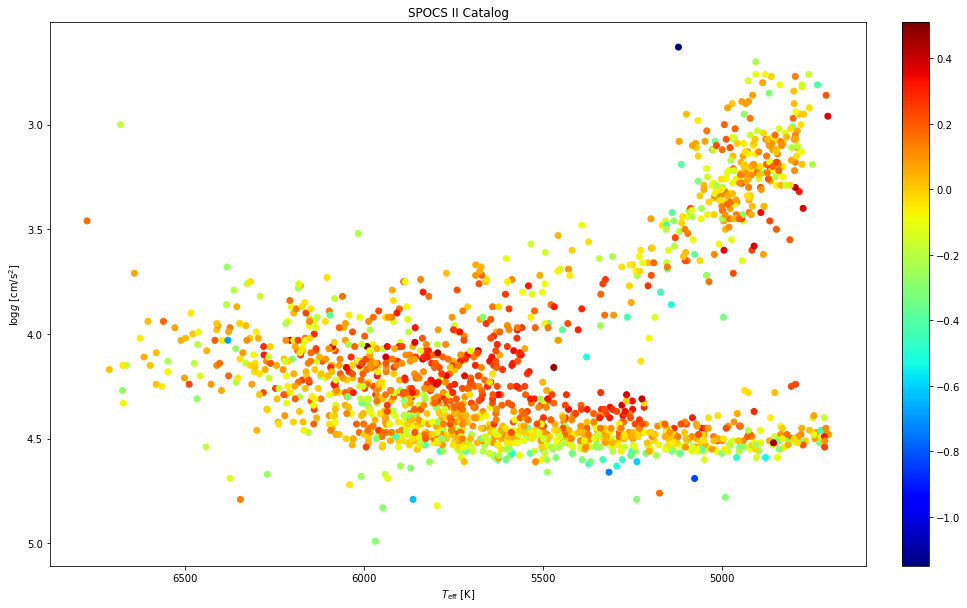

In [24]:
fig, ax = plt.subplots(1,1, figsize=[16,10])

p = ax.scatter(spocs['Teff'],spocs['logg'],c=spocs['[M/H]'],cmap="jet")
cb = fig.colorbar(p, ax=ax, fraction=0.046, pad=0.04)

ax.invert_xaxis() # astronomers plot stellar temperature backwards
ax.invert_yaxis() # Lower log g means larger radius and hence brighter absolute magnitude

t = ax.set_xlabel("$T_{\mathrm{eff}}$ [K]")
t = ax.set_ylabel("$\log{g}$ [cm/s$^2$]")
t = ax.set_title("SPOCS II Catalog")

# Example 2
Histograms and Empirical Probability Distribution Functions are great ways to visualize where your data lies in the parameter space.

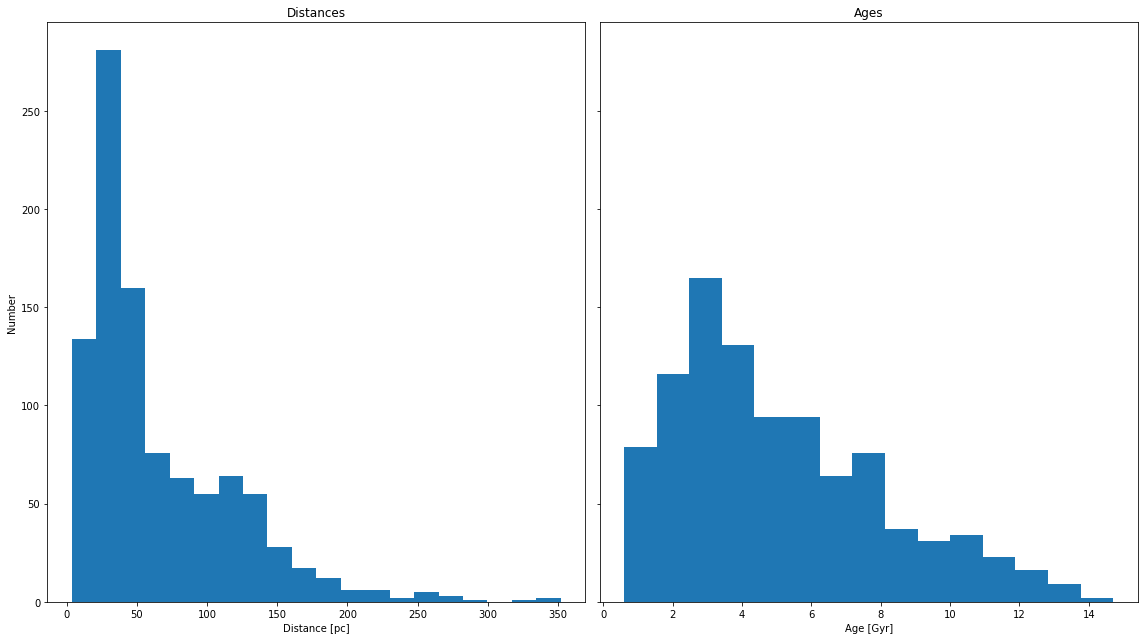

In [57]:
# Histograms are quick and easy ways to visualize the distribution of your data.
# The binning is also fairly straight-forward to understand.  However, the *choice*
# of binning (both size and where to start) can lead to erroneous conclusions about
# the data.  The same is true of PDFs (below) but there are tools to systematically
# choose the bin width (or bandwidth).  You should understand the implications.
#
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, tight_layout=True,figsize=(16,9))

p1 = ax1.hist(spocs['Dist'],bins=20)
t1 = ax1.set_title("Distances")
t1 = ax1.set_xlabel("Distance [pc]")
t1 = ax1.set_ylabel("Number")

p2 = ax2.hist(spocs['Age'],bins=15)
t2 = ax2.set_title("Ages")
t2 = ax2.set_xlabel("Age [Gyr]")

In [47]:
# Use a Gaussian Kernel Density Estimator to find emperical distributions
# of both the distance and the age and replot as Probability Density Function (PDF)
# and Cumulative Distribution Function (CDF)
#
# NOTE: Look up the documentation for this and read the references on how the 'bandwidth'
#       is being selected.  Different bandwidth choices can result in very different
#       PDFs.
#
dist_kde = stats.gaussian_kde(spocs['Dist'])
age_kde = stats.gaussian_kde(spocs['Age'])

In [52]:
dist_range = np.linspace(0,350,100)
age_range = np.linspace(0,14,100)

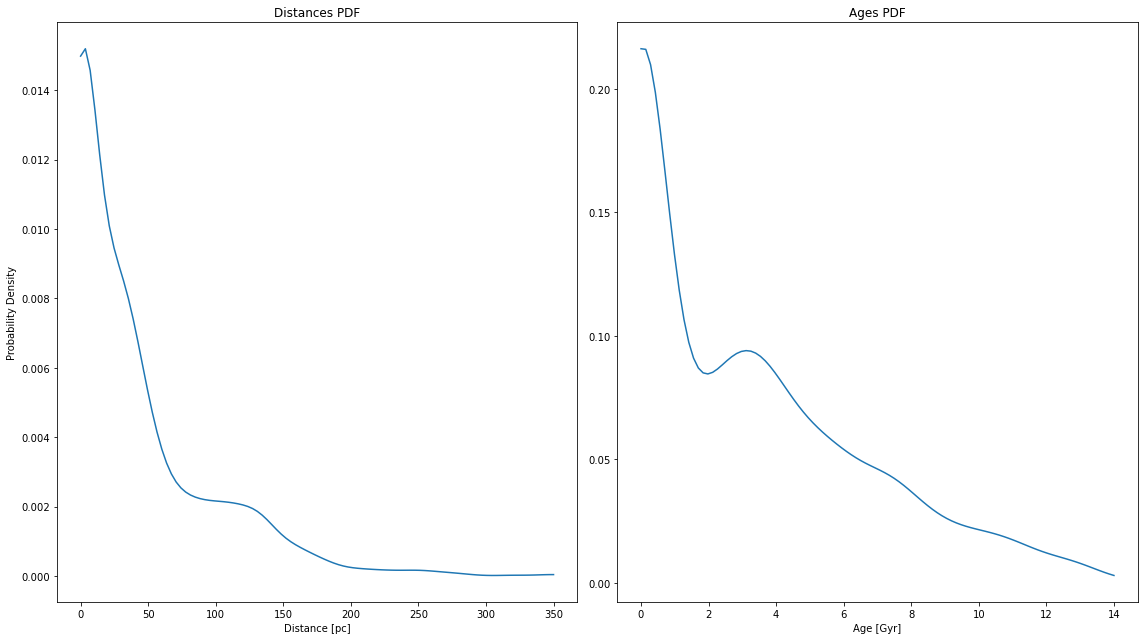

In [53]:
fig, (ax1,ax2) = plt.subplots(1,2,tight_layout=True,figsize=(16,9))

p1 = ax1.plot(dist_range,dist_kde.pdf(dist_range))
t1 = ax1.set_title("Distances PDF")
t1 = ax1.set_xlabel("Distance [pc]")
t1 = ax1.set_ylabel("Probability Density")

p2 = ax2.plot(age_range,age_kde.pdf(age_range))
t2 = ax2.set_title("Ages PDF")
t2 = ax2.set_xlabel("Age [Gyr]")

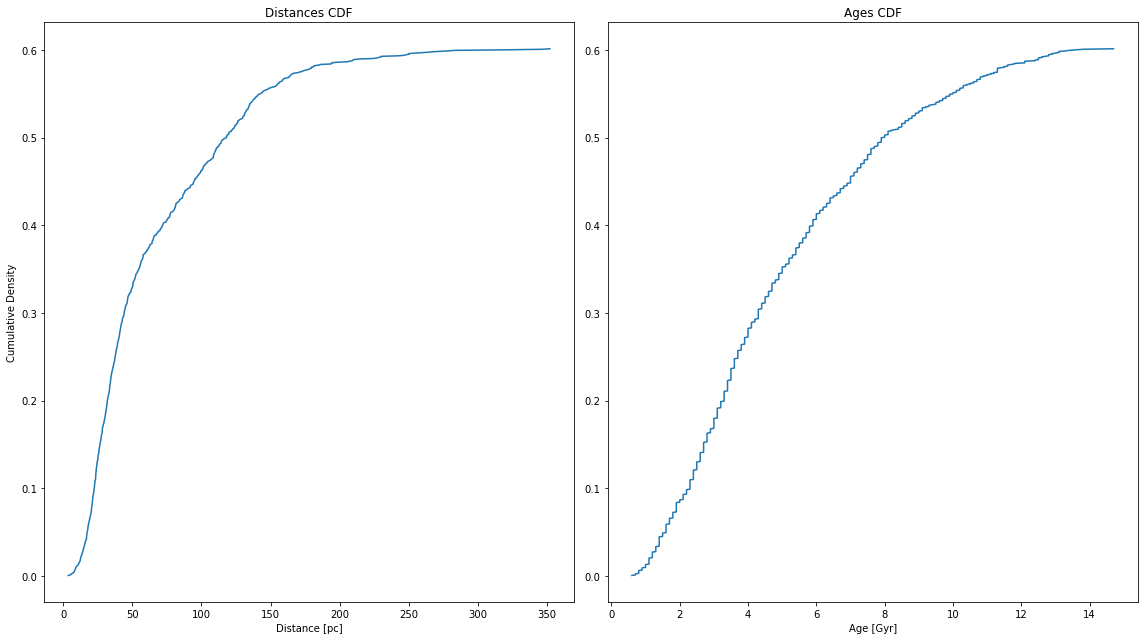

In [56]:
fig, (ax1,ax2) = plt.subplots(1,2,tight_layout=True,figsize=(16,9))

dist_cdf = np.sort(spocs['Dist'])
n = len(dist_cdf)
dist_y = np.arange(1,n+1) / n

age_cdf = np.sort(spocs['Age'])
n = len(age_cdf)
age_y = np.arange(1,n+1) / n

p1 = ax1.plot(dist_cdf,dist_y)
t1 = ax1.set_title("Distances CDF")
t1 = ax1.set_xlabel("Distance [pc]")
t1 = ax1.set_ylabel("Cumulative Density")

p2 = ax2.plot(age_cdf,age_y)
t2 = ax2.set_title("Ages CDF")
t2 = ax2.set_xlabel("Age [Gyr]")

# Excercise 1
Plot the distribution of metallicities using a histrogram or Empirical Probability Density Function

# Example 3
Select stars that have $v \sin{i} < 3$ km/s. Separately, select stars that have S/N > 100.  Re-plot the HR diagram using only those stars.

In [28]:
slow = (spocs['Vsini'] < 3)
highSNR = (spocs['SNR'] > 100)
print("{: 4d} Slow Rotators".format(np.sum(slow)))
print("{: 4d} High S/N".format(np.sum(highSNR)))
print("{: 4d} Slow rotators with high S/N".format(np.sum(slow & highSNR)))

 1126 Slow Rotators
 1191 High S/N
 869 Slow rotators with high S/N


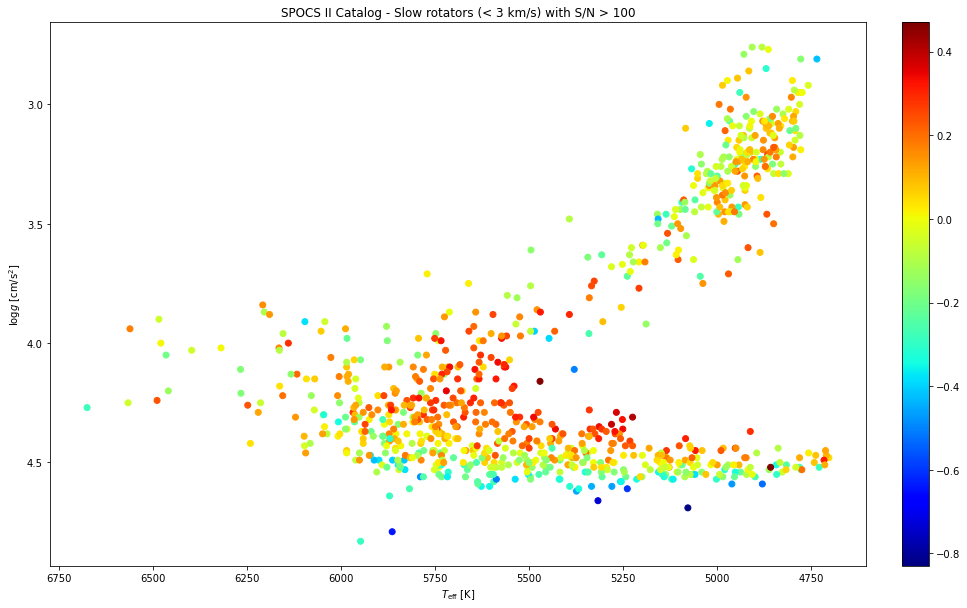

In [29]:
fig, ax = plt.subplots(1,1, figsize=[16,10])

p = ???
cb = ???

ax.invert_xaxis() # astronomers plot stellar temperature backwards
ax.invert_yaxis() # Lower log g means larger radius and hence brighter absolute magnitude

t = ax.set_xlabel("$T_{\mathrm{eff}}$ [K]")
t = ax.set_ylabel("$\log{g}$ [cm/s$^2$]")
t = ax.set_title("SPOCS II Catalog - Slow rotators (< 3 km/s) with S/N > 100")

# Excercise 2
Select the main sequence stars that have above average metallicity.  Plot as in Example 1, but show all of the stars in light grey and smaller symbol and these high metallicity ones with the silicon or oxygen abundance as the color bar.

# Excercise 3
Choose some property of the stars that you are interested in and plot them in different ways to explore the relationship of that property to others that may correlate.  You can import other data related to these stars if you want to explore the relation to parameters not in this data set.